# NIRSpec MOS slits to sky

This notebook demonstrates how to map NIRSpec MSA slits to the sky and back.  
We also show how to extract the wavelength grid from either the `S2D` or `X1D` pipeline products.  
Finally we show the 2D and 1D spectra alongside the color image with slits overlaid, rotated to the orientation of the 2D spectrum.

We use the [ERO 2736](https://www.stsci.edu/cgi-bin/get-proposal-info?observatory=JWST&id=2736) 
G395M observations of [SMACS0723](https://webbtelescope.org/contents/news-releases/2022/news-2022-035), 
source 6355 (z = 7.665) plus a few others.

### Inputs
* NIRSpec `S2D` and `X1D` files for this object from `Spec3Pipeline`
* NIRSpec MSA metafile
* NIRCam image from the [DJA](https://dawn-cph.github.io/dja/index.html)
    * https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits.gz
* (optional) NIRCam color image produced using [Trilogy](https://github.com/dancoe/trilogy)
    * https://relics.stsci.edu/data/smacs0723-73/JWST/smacs0723_color_sw.png
    * alternatively, you could show a single filter image in grayscale
    
    
### Outputs
* Slits drawn on (color) image
* Image mapped back to slit frame

# Import Libraries <a id='import'></a>

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np

In [2]:
from jwst import datamodels

In [3]:
import astropy
#import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack, unique
print('astropy', astropy.__version__)

astropy 6.1.0


In [4]:
from astropy.visualization import simple_norm, SqrtStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [5]:
# To plot and view results

import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, LinearStretch, LogStretch, AsinhStretch, ManualInterval
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [6]:
# Color image

import PIL  # Python Image Library
from PIL import Image, ImageEnhance
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # allow it to load large image

# Helper Functions <a id='helper'></a>

In [7]:
def between(lo, x, hi):
    return (lo <= x) * (x <= hi)

def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [8]:
# Helper functions to select subset of files from list
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

# Select subset of files containing all search strings
def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

In [9]:
def single_value(x):  # True = one number; False = multiple numbers (list / tuple / array / set)
    return isinstance(x, (int, float))

def filter_table(full_table, **kwargs):
    """
    Filters an Astropy Table based an arbitrary number of input column-value pairs.
    Each value can be either a single value or a list (or tuple, array, or set).
    Example:
    select_shutter_table = filter_table(shutter_table, msa_metadata_id=1, dither_point_index=1, source_id=[6355,5144])
    """
    filtered_table = full_table
    for column, value in kwargs.items():
        if single_value(value):
            filtered_table = filtered_table[filtered_table[column] == value]
        else: # list
            filtered_table = filtered_table[[(item in value) for item in filtered_table[column]]]
    return filtered_table

In [10]:
# To retrieve data from MAST
import astroquery
from astroquery.mast import Observations  # MAST
print('astroquery version', astroquery.__version__)

# Helper function to download JWST files from MAST
def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    """
    Helper function to download JWST files from MAST.

    Parameters:
    ----------
    filenames: list of str
        List of filenames to download.
    download_dir: str
        Directory where the files will be downloaded.
    mast_dir: str
        MAST directory containing JWST products.

    Returns:
    -------
    downloaded_files: list of str
        List of downloaded file paths.
    """
    # Download data
    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename = os.path.basename(filename)
        mast_path = os.path.join(mast_dir, filename)
        local_path = os.path.join(download_dir, filename)
        if os.path.exists(local_path):
            print(local_path, 'EXISTS')
        else:
            # Can let this command check if local file exists
            # However, it will delete it if it's there
            # and the wrong size (e.g., reprocessed)
            Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

astroquery version 0.4.7


In [11]:
import requests  # download large file
import tqdm  # shows progress bar while downloading file
import gzip  # decompress .gz file
import shutil

def download_large_file(url, filename='', decompress=True):
    if filename:
        if os.path.isdir(filename):
            filename = os.path.join(filename, os.path.basename(url))
        # else just use the filename as is
    else:
        filename = os.path.basename(url)  # if left blank, just save the filename as in the URL

    decompressed_file = filename
    if decompress:
        if filename[-3:] == '.gz':
            decompressed_file = filename[:-3]
            
    if os.path.exists(decompressed_file):
        if os.path.getsize(decompressed_file):
            print(decompressed_file, 'EXISTS')
            return decompressed_file
    
    print('Downloading', url)
    print('to:', filename)

    with open(filename, 'wb') as f:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))

            # tqdm has many interesting parameters. Feel free to experiment!
            tqdm_params = {
                #'desc': url,
                'total': total,
                'miniters': 1,
                'unit': 'B',
                'unit_scale': True,
                'unit_divisor': 1024,
                'bar_format': '{l_bar}{bar:20}{r_bar}{bar:-20b}',  # progress bar length 20 pixels
            }
            with tqdm.tqdm(**tqdm_params) as pb:
                for chunk in r.iter_content(chunk_size=8192):
                    pb.update(len(chunk))
                    f.write(chunk)
                      
            if decompress:
                if filename[-3:] == '.gz':
                    print('Decompressing to:', decompressed_file, '...')
                    with gzip.open(filename, 'rb') as f_in:
                        with open(decompressed_file, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    
                    # Clean up: remove compressed file, now that you've decompressed it
                    if os.path.exists(filename):
                        if os.path.getsize(filename):
                            os.remove(filename)
                            
                    filename = decompressed_file
            
    return filename

# Select source

In [12]:
source_id = 6355  # z = 7.665

# Download files

We'll download them from MAST. You may instead load files you've reprocessed.

In [13]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [14]:
# 2D spectrum filename
s2d_file = 'jw02736-o007_s%05d_nirspec_f290lp-g395m_s2d.fits' % source_id
s2d_file

'jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [15]:
# Download 2D spectrum
s2d_file = download_jwst_files([s2d_file], data_dir)[0]
s2d_file

data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits EXISTS


'data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [16]:
# Download 1D spectrum
x1d_file = s2d_file.replace('s2d', 'x1d')
x1d_file = download_jwst_files([x1d_file], data_dir)[0]
x1d_file

data/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits EXISTS


'data/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits'

# Load spectra

into datamodels

In [17]:
s2d_model = datamodels.open(s2d_file)
#s2d_model.info(max_rows=99999)  # show all contents
#s2d_data = s2d_model.data + 0

In [18]:
if 'slits' in list(s2d_model):  # Spec2 s2d has all the objects; extract the one with source_id
    source_ids = [slit.source_id for slit in s2d_model.slits]
    i_slit = source_ids.index(source_id)
    slit_model = s2d_model.slits[i_slit]
else:  # Spec3 s2d only has one object
    slit_model = s2d_model
    i_slit = 0

s2d_data = slit_model.data + 0  # load and make copy
s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

In [19]:
# Load 1D extraction
x1d_model = datamodels.open(x1d_file)
#x1d_model.info(max_rows=99999)  # show all contents

### wavelength grid from x1d file

The S2D spectrum is on the same wavelength grid

In [20]:
x1d_wave = x1d_model.spec[i_slit].spec_table.WAVELENGTH
x1d_wave  # identical to s2d_wave below

array([2.84859723, 2.85039149, 2.85218575, ..., 5.28289045, 5.28467829,
       5.28646621])

alternatively, you can extract the wavelength grid from the S2D datamodel:

### S2D model WCS transform –> RA, Dec, wavelength

https://jwst-pipeline.readthedocs.io/en/latest/_modules/jwst/assign_wcs/nirspec.html

S2D datamodel encodes WCS transforms, including detector to world coordinates, which includes the wavelength grid

In [21]:
# WCS transformations
slit_wcs = slit_model.meta.wcs
det_to_sky  = slit_wcs.get_transform('detector',   'world') # coordinate transform from detector pixels to sky 
slit_to_sky = slit_wcs.get_transform('slit_frame', 'world')
sky_to_slit = slit_wcs.get_transform('world',      'slit_frame')

In [22]:
y_s2d, x_s2d = np.mgrid[:s2d_data.shape[0], :s2d_data.shape[1]] # grid of pixel x,y indices 
ra_s2d, dec_s2d, s2d_waves = det_to_sky(x_s2d, y_s2d) # RA, Dec, wavelength (microns) for each pixel 
ra_s2d  = ra_s2d[:,0]  # RA,Dec only defined in the spatial cross-dispersion direction
dec_s2d = dec_s2d[:,0] # RA,Dec only defined in the spatial cross-dispersion direction
s2d_wave = s2d_waves[0,:] # wavelength only defined in the dispersion direction
# every row is identical in the rectified spectrum 
s2d_wave

array([2.84859723, 2.85039149, 2.85218575, ..., 5.28289045, 5.28467829,
       5.28646621])

# MSA Metafile

In [23]:
# Get name of MSA metafile from S2D file header
msa_metafile = fits.getval(s2d_file, 'MSAMETFL')
msa_metafile

'jw02736007001_01_msa.fits'

In [24]:
# Download MSA metafile
msa_metafile = download_jwst_files([msa_metafile], './')[0]
msa_metafile

./jw02736007001_01_msa.fits EXISTS


'./jw02736007001_01_msa.fits'

In [25]:
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: ./jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   1318R x 12C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [26]:
#msa_hdu_list['SHUTTER_IMAGE'].data.shape
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)
source_table  = Table(msa_hdu_list['SOURCE_INFO'].data)

In [27]:
set(shutter_table['msa_metadata_id'])  # can have multiple MSA configs

{1, 76}

In [28]:
dithers = list(set(shutter_table['dither_point_index']))
dithers

[1, 2, 3]

In [29]:
source_ids = set(shutter_table['source_id'])
source_ids = np.sort(list(source_ids))
source_ids

array([   -62,    -61,    -60,    -59,    -58,    -57,    -56,    -55,
          -54,    -53,    -52,    -51,    -50,    -49,    -48,    -47,
          -46,    -45,    -44,    -43,    -42,    -41,    -40,    -39,
          -38,    -37,    -36,    -35,    -34,    -33,    -32,    -31,
          -30,    -29,    -28,    -27,    -26,    -25,    -24,    -23,
          -22,    -21,    -20,    -19,    -18,    -17,    -16,    -15,
          -14,    -13,    -12,    -11,    -10,     -9,     -8,     -7,
           -6,     -5,     -4,     -3,     -2,     -1,      0,   1370,
         1679,   1917,   2038,   2572,   2653,   3042,   3772,   4580,
         4590,   4592,   4798,   4805,   5144,   5735,   5992,   6113,
         6355,   7570,   7677,   8140,   8277,   8311,   8312,   8498,
         8506,   8717,   8730,   8883,   8886,   8981,   9239,   9483,
         9721,   9922,  10380,  10389,  10390,  10392,  10444,  10511,
        10612, 101449, 102423, 102539, 102673, 102711, 102730, 102738,
      

In [30]:
select_source_table = filter_table(source_table, source_id=source_id)
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,0.1


In [31]:
#source_ra, source_dec = 110.8446, -73.43506
source_ra  = select_source_table['ra'][0]
source_dec = select_source_table['dec'][0]
source_ra, source_dec

(110.84459416965377, -73.4350589621277)

In [32]:
source_shutter_table = filter_table(shutter_table, dither_point_index=1, msa_metadata_id=1, source_id=source_id)
source_shutter_table

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
72,1,3,138,83,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,84,6355,N,OPEN,0.46437824,0.86562544,1,Y
72,1,3,138,85,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,86,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,87,6355,Y,OPEN,nan,nan,1,N


In [33]:
i_primary = list(source_shutter_table['primary_source']).index('Y')
i_primary

1

# NIRCam Color Image

Created with [Trilogy](https://github.com/dancoe/trilogy)
using [NIRCam images in the DAWN JWST Archive (DJA)](https://dawn-cph.github.io/dja/imaging/v7/)

Alternatively, you can show a single filter image in grayscale

In [34]:
# Download a color image if you have one
# It should be on the same pixel grid as the FITS image you'll download next after this

showing_color_image = True  # controls the plotting later

# Trilogy NIRCam SW color image (226 MB)
color_image_file = 'https://relics.stsci.edu/data/smacs0723-73/JWST/smacs0723_color_sw.png'
color_image_file = download_large_file(color_image_file, data_dir)
color_image_file

to: data/smacs0723_color_sw.png


100%|████████████████████| 226M/226M [00:17<00:00, 13.6MB/s]                                                                                                 


'data/smacs0723_color_sw.png'

In [35]:
# Load single filter FITS image for WCS header to convert RA, Dec -> x, y
# NIRCam F200W FITS image from DJA (371 MB)
NIRCam_image_file = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits.gz'
NIRCam_image_file = download_large_file(NIRCam_image_file, data_dir)
NIRCam_image_file

to: data/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits.gz


100%|████████████████████| 371M/371M [00:42<00:00, 9.12MB/s]                                                                                                 


Decompressing to: data/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits ...


'data/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits'

In [36]:
image_hdulist = fits.open(NIRCam_image_file)
idata = 0
image_wcs = wcs.WCS(image_hdulist[idata].header, image_hdulist)
image_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 110.83403 -73.45429 
CRPIX : 9182.5 13030.5 
CD1_1 CD1_2  : -5.5555555555555e-06 0.0 
CD2_1 CD2_2  : 0.0 5.5555555555555e-06 
NAXIS : 24000  24000

In [37]:
color_image_file

'data/smacs0723_color_sw.png'

In [38]:
if showing_color_image:
    im = Image.open(color_image_file)
    im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
    NIRCam_image = np.asarray(im)
    # Takes a few seconds to load a large image    

else:
    # just load single image
    NIRCam_image = fits.open(NIRCam_image_file)[0].data

# Define slit sizes

In [39]:
open_slit_x_size = 0.20  # open slit width  in arcseconds (dispersion direction)
open_slit_y_size = 0.46  # open slit height in arcseconds (cross-dispersion direction)
slit_bar_width   = 0.07  # bar width=height in arcseconds (between the slits)

open_slit_aspect = open_slit_y_size / open_slit_x_size

full_slit_x_size = open_slit_x_size + slit_bar_width
full_slit_y_size = open_slit_y_size + slit_bar_width
full_slit_aspect = full_slit_y_size / full_slit_x_size
full_slit_x_size, full_slit_y_size

(0.27, 0.53)

In [40]:
x_scale_open_to_full = full_slit_x_size / open_slit_x_size
y_scale_open_to_full = full_slit_y_size / open_slit_y_size
x_scale_open_to_full, y_scale_open_to_full

(1.35, 1.1521739130434783)

# Mapping Slits to the Sky

In [41]:
# Slit corners in coordinates that range from (0,0) to (1,1)
open_slit_x_corners = 0, 0, 1, 1 
open_slit_y_corners = 0, 1, 1, 0

# Convert coordinates to slit centroid at (0,0)
open_slit_x_corners = np.array(open_slit_x_corners) - 0.5
open_slit_y_corners = np.array(open_slit_y_corners) - 0.5

# Convert to full slit (not just open area)
full_slit_x_corners = x_scale_open_to_full * open_slit_x_corners
full_slit_y_corners = y_scale_open_to_full * open_slit_y_corners

In [42]:
# MSA metafile estimate of source position within shutter slitlet
# Coordinates range from (0,0) to (1,1)
estimated_source_in_shutter_x = source_shutter_table['estimated_source_in_shutter_x'][i_primary]
estimated_source_in_shutter_y = source_shutter_table['estimated_source_in_shutter_y'][i_primary]
#estimated_source_in_shutter_x, estimated_source_in_shutter_y

# Convert coordinates to slit centroid at (0,0)
estimated_source_in_shutter_x -= 0.5
estimated_source_in_shutter_y -= 0.5

# Coordinates are actually for full slit (not just open area)
estimated_source_in_shutter_x *= x_scale_open_to_full
estimated_source_in_shutter_y *= y_scale_open_to_full

# Transform to sky (RA,Dec) using S2D WCS transformation
estimated_source_ra, estimated_source_dec, zero = slit_to_sky(
    estimated_source_in_shutter_x, estimated_source_in_shutter_y, 0)

# Transform to image pixels (x,y) using image WCS
estimated_source_coordinates = SkyCoord(ra=estimated_source_ra*u.deg, dec=estimated_source_dec*u.deg)
estimated_source_x, estimated_source_y = image_wcs.world_to_pixel(estimated_source_coordinates)

estimated_source_x, estimated_source_y

(array(8639.80466798), array(16485.56199579))

In [43]:
# Indices to iterate along slit with multiple shutters
# (e.g., dy_columns = -1,0,1 for 3-shutter slitlet)
dx_rows    = source_shutter_table['shutter_row']    - source_shutter_table['shutter_row'][i_primary]
dy_columns = source_shutter_table['shutter_column'] - source_shutter_table['shutter_column'][i_primary]

# Scale to full slit (not just open area)
dx_slit = np.array(dx_rows)    * x_scale_open_to_full
dy_slit = np.array(dy_columns) * y_scale_open_to_full
# Note the cross-dispersion direction is defined as columns in the MSA metafile
# even though we normally show them as rows in the MSA
dy_slit  

array([-1.15217391,  0.        ,  1.15217391,  2.30434783,  3.45652174])

In [44]:
# Calculate offset between S2D WCS transformation and actual coordinates in input catalog
# The input catalog coordinates (RA,Dec) are more accurate
source_coordinates = SkyCoord(ra=source_ra*u.deg, dec=source_dec*u.deg)
source_xy = source_x, source_y = image_wcs.world_to_pixel(source_coordinates)

# We'll correct for this offset below
dx_obs = estimated_source_x - source_x
dy_obs = estimated_source_y - source_y

dx_obs, dy_obs

(0.44040891860095144, -5.477046126175992)

In [45]:
# Convert full slit corner coordinates to sky using S2D WCS transformation slit_to_sky
xx = []
yy = []

for i in range(len(dy_columns)):
    slitlet_ra, slitlet_dec, zero = slit_to_sky(full_slit_x_corners + dx_slit[i], full_slit_y_corners + dy_slit[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    xx.append(x)
    yy.append(y)

# Define the image stamp region: a 3"x3" square around the center of the slits
dx = 75  # half-width in pixels (0.02" * 75 pixels = 1.5", so the image will be 3"x3")
slices, extent = slices_extent(np.mean(xx), np.mean(yy), dx)
xlo, xhi, ylo, yhi = extent
np.mean(xx), np.mean(yy)

(8626.327030078093, 16475.20981900441)

In [46]:
slit_color = 'r'
source_color = (0, 0.8, 0)  # green

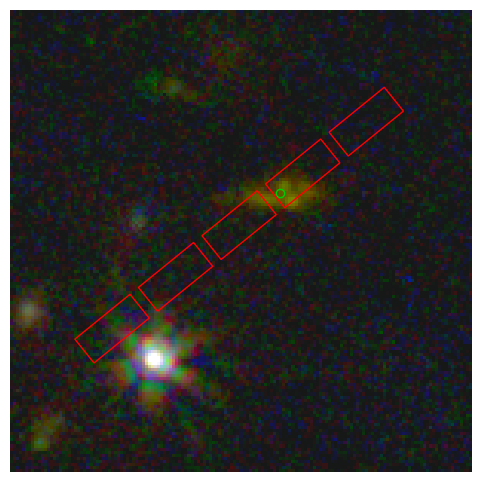

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))

if showing_color_image:
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower')
else:  # grayscale
    norm = simple_norm(NIRCam_image[slices], 'asinh', percent=99)
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower', cmap='gray', norm=norm)

plt.plot(source_x, source_y, 'o', mec=source_color, mfc='None')

for i in range(len(source_shutter_table)):
    slitlet_ra, slitlet_dec, zero = slit_to_sky(open_slit_x_corners + dx_slit[i], open_slit_y_corners + dy_slit[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    x -= dx_obs
    y -= dy_obs
    xy = np.array([x, y]).T
    patch = matplotlib.patches.Polygon(xy, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

ax.axis('off')  # hide the axis coordinates, ticks, and labels
plt.show()

## Show the correction that enabled this

The slits (RA,Dec) derived from the S2D WCS transform is a bit off.  
Taking it at face value, we estimate the source position (RA,Dec) based on the estimated position within the slit, which is more accurate.  
We compare this to actual source position (RA,Dec) from the catalog in the MSA file.  
We use the offset to correct the slit positions (RA,Dec).

In [48]:
wcs_slit_color = 'gray'
wcs_source_color = 'g'

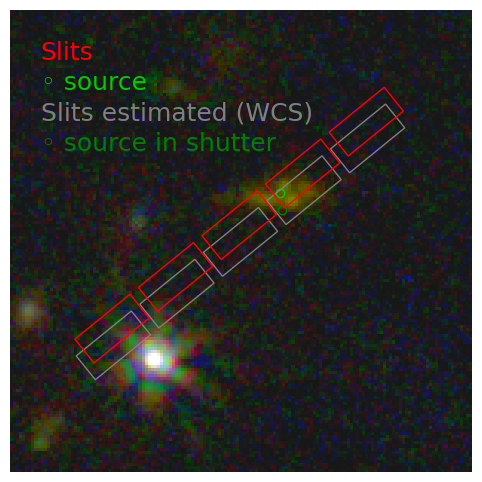

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))

if showing_color_image:
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower')
else:
    norm = simple_norm(NIRCam_image[slices], 'asinh', percent=99)
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower', cmap='gray', norm=norm)

plt.plot(estimated_source_x, estimated_source_y, 'o', mec=wcs_source_color, mfc='None')
plt.plot(          source_x,           source_y, 'o', mec=source_color,     mfc='None')

for i in range(len(source_shutter_table)):
    # slit coordinates from WCS transform
    slitlet_ra, slitlet_dec, zero = slit_to_sky(open_slit_x_corners + dx_slit[i], open_slit_y_corners + dy_slit[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    wcs_slit_x, wcs_slit_y = image_wcs.world_to_pixel(slit_coordinates)
    wcs_slit_xy = np.array([wcs_slit_x, wcs_slit_y]).T
    patch = matplotlib.patches.Polygon(wcs_slit_xy, fc='None', ec=wcs_slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

    # Correction 
    slit_x = wcs_slit_x - dx_obs
    slit_y = wcs_slit_y - dy_obs
    slit_xy = np.array([slit_x, slit_y]).T
    patch = matplotlib.patches.Polygon(slit_xy, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

plt.text(xlo+10, yhi-10, 'Slits',                 color=slit_color,       va='top', fontsize=18)
plt.text(xlo+10, yhi-20, '◦ source',              color=source_color,     va='top', fontsize=18)
plt.text(xlo+10, yhi-30, 'Slits estimated (WCS)', color=wcs_slit_color,   va='top', fontsize=18)
plt.text(xlo+10, yhi-40, '◦ source in shutter',   color=wcs_source_color, va='top', fontsize=18)

ax.axis('off')  # hide the axis coordinates, ticks, and labels
plt.show()

### S2D spatial cross-dispersion direction mapped to sky (RA,Dec)

In [50]:
s2d_coordinates = SkyCoord(ra=ra_s2d*u.deg, dec=dec_s2d*u.deg)
s2d_x, s2d_y = image_wcs.world_to_pixel(s2d_coordinates)

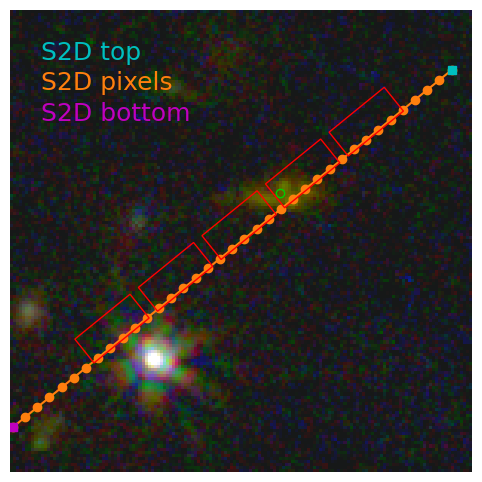

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))

if showing_color_image:
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower')
else:
    norm = simple_norm(NIRCam_image[slices], 'asinh', percent=99)
    ax.imshow(NIRCam_image[slices], extent=extent, origin='lower', cmap='gray', norm=norm)

plt.plot(source_x, source_y, 'o', mec=source_color, mfc='None')

for i in range(len(source_shutter_table)):
    slitlet_ra, slitlet_dec, zero = slit_to_sky(open_slit_x_corners + dx_slit[i], open_slit_y_corners + dy_slit[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    x -= dx_obs
    y -= dy_obs
    xy = np.array([x, y]).T
    patch = matplotlib.patches.Polygon(xy, fc='None', ec=slit_color, alpha=1, zorder=100)
    ax.add_patch(patch)

plt.plot(s2d_x, s2d_y, '-o')
plt.plot(s2d_x[-1], s2d_y[-1], 's', color='c')
plt.plot(s2d_x[0],  s2d_y[0],  's', color='m')

plt.text(xlo+10, yhi-10, 'S2D top',    color='c',  va='top', fontsize=18)
plt.text(xlo+10, yhi-20, 'S2D pixels', color='C1', va='top', fontsize=18)
plt.text(xlo+10, yhi-30, 'S2D bottom', color='m',  va='top', fontsize=18)

ax.axis('off')  # hide the axis coordinates, ticks, and labels
plt.show()

# Mapping Sky back to Slits

In [52]:
# Use full extent of S2D in spatial cross-dispersion direction
slit_x, slit_y, zero = sky_to_slit(ra_s2d, dec_s2d, 0)  # slit coordinates
y_slit_lo = slit_y[0]
y_slit_hi = slit_y[-1]
y_slit_lo, y_slit_hi

# Single slit width + some padding in the dispersion direction
x_slit_hi = 1.2  # 1.0 is just the open slit + half bar; add extra for padding
x_slit_lo = - (x_slit_hi - 1)
x_slit_lo, x_slit_hi = x_slit_hi, x_slit_lo  # need to transpose?

print('x:', x_slit_lo, x_slit_hi)
print('y:', y_slit_lo, y_slit_hi)

x: 1.2 -0.19999999999999996
y: 5.277980963431614 -2.6735769523237938


In [53]:
# Create a high-resolution coordinate grid spanning that extent in the slit plane
nx_slit_image = 100
ny_slit_image = nx_slit_image * full_slit_aspect * (y_slit_hi - y_slit_lo)
y_slit, x_slit = np.mgrid[y_slit_lo:y_slit_hi:ny_slit_image*1j, x_slit_lo:x_slit_hi:nx_slit_image*1j] - 0.5
x_slit *= x_scale_open_to_full
y_slit *= y_scale_open_to_full
ny_slit, nx_slit = y_slit.shape

# Transform these coordinates to the image plane
ra_slit, dec_slit, zero = slit_to_sky(x_slit, y_slit, 0)
coords_slit = SkyCoord(ra=ra_slit*u.deg, dec=dec_slit*u.deg)
x_image, y_image = image_wcs.world_to_pixel(coords_slit)

# Extract the image values (colors) at each coordinate
slit_stamp = NIRCam_image[np.round(y_image-dy_obs).astype(int), np.round(x_image-dx_obs).astype(int)]
if np.all(slit_stamp == slit_stamp[0]):  # all the same value probably means no data
    slit_stamp = 128 + 0 * slit_stamp  # make gray for no data

slit_extent = x_slit[0,0], x_slit[0,-1], y_slit[0,0], y_slit[-1,0]

In [54]:
# If dithered, then show extra background slitlets on either side
slit_bkg_color = 0.88, 0.7, 0.7  # light red
extend_length = int(dithers[-1] - np.mean(dithers))
dy_columns_extended = np.arange(dy_columns[0]-extend_length, dy_columns[-1]+extend_length+1)
dy_columns_extended

array([-2, -1,  0,  1,  2,  3,  4])

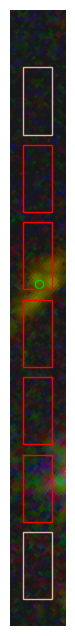

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(2, 8))

# Show image;  don't bother checking if it's color or grayscale:
# cmap will be ignored for color image; and automatic linear scaling could be okay in this region
ax.imshow(slit_stamp, origin='lower', aspect=open_slit_aspect, extent=slit_extent, cmap='gray')

# Draw slits
for dy in dy_columns_extended:
    if between(dy_columns[0], dy, dy_columns[-1]):
        color = slit_color
    else: # background dithers
        color = slit_bkg_color
    xy_corners = np.array([open_slit_x_corners, open_slit_y_corners + dy * y_scale_open_to_full]).T
    patch = matplotlib.patches.Polygon(xy_corners, fc='None', ec=color, alpha=1, zorder=100)
    ax.add_patch(patch)

plt.plot(estimated_source_in_shutter_x, estimated_source_in_shutter_y, 'o', mec=source_color, mfc='None')

plt.axis('off');  # hide the axis coordinates, ticks, and labels

# Show image alongside spectrum

In [56]:
def extract_slit_from_table(source_id, slit_to_sky):
    source_shutter_table = filter_table(shutter_table, dither_point_index=1, msa_metadata_id=1, source_id=source_id)
    if not source_shutter_table:
        return []
    
    i_primary = list(source_shutter_table['primary_source']).index('Y')

    select_source_table = source_table[source_table['source_id'] == source_id]
    source_ra  = select_source_table['ra'][0]
    source_dec = select_source_table['dec'][0]

    estimated_source_in_shutter_x = source_shutter_table['estimated_source_in_shutter_x'][i_primary]
    estimated_source_in_shutter_y = source_shutter_table['estimated_source_in_shutter_y'][i_primary]

    # Shift coordinate centroid to (0,0)
    estimated_source_in_shutter_x -= 0.5
    estimated_source_in_shutter_y -= 0.5

    # Coordinates are actually for full slit (not just open area)
    estimated_source_in_shutter_x *= x_scale_open_to_full
    estimated_source_in_shutter_y *= y_scale_open_to_full

    # Transform to sky (RA,Dec) using S2D WCS transformation
    estimated_source_ra, estimated_source_dec, zero = slit_to_sky(
        estimated_source_in_shutter_x, estimated_source_in_shutter_y, 0)

    # Transform to image pixels (x,y) using image WCS
    estimated_source_coordinates = SkyCoord(ra=estimated_source_ra*u.deg, dec=estimated_source_dec*u.deg)
    estimated_source_x, estimated_source_y = image_wcs.world_to_pixel(estimated_source_coordinates)

    # Calculate offset between S2D WCS transformation and actual coordinates in input catalog
    # The input catalog coordinates (RA,Dec) are more accurate than the pipeline (RA,Dec)
    source_coordinates = SkyCoord(ra=source_ra*u.deg, dec=source_dec*u.deg)
    source_xy = source_x, source_y = image_wcs.world_to_pixel(source_coordinates)

    # We'll correct for this offset below
    dx_obs = estimated_source_x - source_x
    dy_obs = estimated_source_y - source_y

    # Indices to iterate along slit with multiple shutters
    # (e.g., dy_columns = -1,0,1 for 3-shutter slitlet)
    dx_rows    = source_shutter_table['shutter_row']    - source_shutter_table['shutter_row'][i_primary]
    dy_columns = source_shutter_table['shutter_column'] - source_shutter_table['shutter_column'][i_primary]

    # Scale to full slit (not just open area)
    # No, do this later
    #dx_rows    = np.array(dx_rows)    * x_scale_open_to_full
    #dy_columns = np.array(dy_columns) * y_scale_open_to_full

    # Note the cross-dispersion direction is defined as columns in the MSA metafile
    # even though we normally show them as rows in the MSA

    return i_primary, dy_columns, dx_obs, dy_obs, estimated_source_in_shutter_x, estimated_source_in_shutter_y

In [57]:
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w', expand_wavelength_gap=True,
                      plot_image=True, save_plot=False, save_dir='plots', figsize=(12,6), x_slit_hi=1.2,
                      sigma_2d=5,  maxiters_2d=3,  # 2D spectrum clipping
                      ymargin_1d_pos = 1.1,  # margin above max
                      sigma_1d_pos=1000, maxiters_1d_pos=1,  # 1D spectrum clipping
                      sigma_1d_neg=10,   maxiters_1d_neg=3,  # 1D spectrum clipping
                      ymin=None, ymax=None, wave_tick_interval=0.2, wave_tick_fmt='%.1f'): #, bad_color=(0.88,0.88,0.88)):

    # 2D spectrum
    if 'slits' in list(s2d_model):  # s2d from Spec2 has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d from Spec3 has only one object from one detector
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data

    # Expand the wavelength array for the gap?
    if expand_wavelength_gap:
        # calculate differences between consecutive wavelengths and
        # find if there is a gap to fill
        dx1d_wave = x1d_wave[1:] - x1d_wave[:-1]
        igap = np.argmax(dx1d_wave)
        dx1d_max = np.max(dx1d_wave)
        dx_replace = (dx1d_wave[igap-1] + dx1d_wave[igap+1]) / 2.
        num_fill = int(np.round(dx1d_max / dx_replace))
        print("Expanding wavelength gap %.2f -- %.2f microns"
              % (x1d_wave[igap], x1d_wave[igap+1]))

        if num_fill > 1:  # There is a gap to fill
            wave_fill = np.mgrid[x1d_wave[igap] : x1d_wave[igap+1] : (num_fill+1)*1j]
            x1d_wave = np.concatenate([x1d_wave[:igap+1], wave_fill[1:-1], x1d_wave[igap+1:]])

            num_rows, num_waves = s2d_data.shape
            s2d_fill = np.zeros(shape=(num_rows, num_fill-1)) * np.nan
            s2d_data = np.concatenate([s2d_data[:, :igap+1], s2d_fill, s2d_data[:, igap+1:]], axis=1)

            x1d_fill = np.zeros(shape=(num_fill-1)) * np.nan
            x1d_flux = np.concatenate([x1d_flux[:igap+1], x1d_fill, x1d_flux[igap+1:]])
            x1d_fluxerr = np.concatenate([x1d_fluxerr[:igap+1], x1d_fill, x1d_fluxerr[igap+1:]])

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    xtick_min = np.ceil((wave_min - eps) / wave_tick_interval) * wave_tick_interval
    xticks = np.arange(xtick_min, wave_max, wave_tick_interval)
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = [wave_tick_fmt % xtick for xtick in xticks]

    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''

    # WCS transformations
    slit_wcs = slit_model.meta.wcs
    det_to_sky = slit_wcs.get_transform('detector', 'world') # coordinate transform from detector pixels to sky 
    slit_to_sky = slit_wcs.get_transform('slit_frame', 'world')
    sky_to_slit = slit_wcs.get_transform('world', 'slit_frame')

    # Extract slit from tables
    slit_list = extract_slit_from_table(source_id, slit_to_sky)
    if slit_list and plot_image:
    
        i_primary, dy_columns, dx_obs, dy_obs, \
        estimated_source_in_shutter_x, estimated_source_in_shutter_y = slit_list        

        # Make FIGURE
        #fig = plt.figure(figsize=(18,10))
        fig = plt.figure(figsize=figsize)
        grid = plt.GridSpec(2, 2, width_ratios=[1, 12*1.2/x_slit_hi], height_ratios=[1, 3], wspace=0.02, hspace=0.12)

        ax_image = fig.add_subplot(grid[:, 0])
        ax_2d    = fig.add_subplot(grid[0, 1])
        ax_1d    = fig.add_subplot(grid[1, 1], sharex=ax_2d)

        # IMAGE
        ax_image.axis('off')
    
        y_s2d = np.arange(s2d_data.shape[0]) # grid of pixel y indices: spatial cross-dispersion
        x_s2d = y_s2d * 0  # dispersion direction irrelevant for RA, Dec
        ra_s2d, dec_s2d, s2d_waves = det_to_sky(x_s2d, y_s2d) # RA, Dec, wavelength (microns) for each pixel 
        slit_x, slit_y, zero = sky_to_slit(ra_s2d, dec_s2d, 0)  # slit coordinates

        y_slit_lo = slit_y[0]
        y_slit_hi = slit_y[-1]

        # x_slit_hi = 1.2  # 1.0 is just the slit + half bar; add extra for padding
        x_slit_lo = - (x_slit_hi - 1)
        x_slit_lo, x_slit_hi = x_slit_hi, x_slit_lo  # need to transpose?

        # Create a high-resolution coordinate grid in the slit plane
        nx_slit_image = 100
        ny_slit_image = nx_slit_image * full_slit_aspect * (y_slit_hi - y_slit_lo)
        y_slit, x_slit = np.mgrid[y_slit_lo:y_slit_hi:ny_slit_image*1j, x_slit_lo:x_slit_hi:nx_slit_image*1j] - 0.5
        x_slit *= x_scale_open_to_full
        y_slit *= y_scale_open_to_full
        ny_slit, nx_slit = y_slit.shape

        # Transform these to the image plane
        ra_slit, dec_slit, zero = slit_to_sky(x_slit, y_slit, 0)
        coords_slit = SkyCoord(ra=ra_slit*u.deg, dec=dec_slit*u.deg)
        x_image, y_image = image_wcs.world_to_pixel(coords_slit)

        # Extract the image values (colors) at each coordinate
        slit_stamp = NIRCam_image[np.round(y_image-dy_obs).astype(int), np.round(x_image-dx_obs).astype(int)]
        if np.all(slit_stamp == slit_stamp[0]):  # all the same value probably means no data
            slit_stamp = 128 + 0 * slit_stamp  # make gray for no data
            
        slit_extent = x_slit[0,0], x_slit[0,-1], y_slit[0,0], y_slit[-1,0]
        #print('ymin, xmin', np.min(y_image-dy_obs), np.min(x_image-dx_obs))
        #print(source_id, i_primary, dy_columns, dx_obs, dy_obs)

            
        # Plot image
        ax_image.imshow(slit_stamp, origin='lower', aspect=open_slit_aspect, extent=slit_extent)
    
        dy_columns_extended = list(dy_columns) + [dy_columns[0] - 1] +  [dy_columns[-1] + 1]

        for dy in dy_columns_extended:
            #print('dy', dy)
            if between(dy_columns[0], dy, dy_columns[-1]):
                color = slit_color
            else:
                color = slit_bkg_color
            xy_corners = np.array([open_slit_x_corners, open_slit_y_corners + dy * y_scale_open_to_full]).T
            patch = matplotlib.patches.Polygon(xy_corners, fc='None', ec=color, alpha=1, zorder=100)
            ax_image.add_patch(patch)

        ax_image.plot(estimated_source_in_shutter_x, estimated_source_in_shutter_y, 'o', mec=source_color, mfc='None')

    else: 
        # Make FIGURE -- no image
        fig = plt.figure(figsize=figsize)
        grid = plt.GridSpec(2, 1, height_ratios=[1, 3], wspace=0.03, hspace=0.1)

        #ax_image = fig.add_subplot(grid[:, 0])
        ax_2d    = fig.add_subplot(grid[0])
        ax_1d    = fig.add_subplot(grid[1], sharex=ax_2d)


    # 2D spectrum
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    sigma_clipped_data = sigma_clip(s2d_data, sigma=sigma_2d, maxiters=maxiters_2d)
    ymin_2d = np.min(sigma_clipped_data)
    ymax_2d = np.max(sigma_clipped_data)
    print('2D limits:', ymin_2d, ymax_2d)

    # Plot the rectified 2D spectrum
    norm = ImageNormalize(vmin=ymin_2d, vmax=ymax_2d, stretch=LinearStretch())
    #norm = simple_norm(s2d_data, 'linear', vmin=ymin_2d, vmax=ymax_2d)
    im = ax_2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    ny, nx = s2d_data.shape
    ax_2d.yaxis.set_ticks_position('right')

    # Plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax_1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax_1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax_1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax_1d.set_xlim(0, num_waves)
    ax_1d.yaxis.set_ticks_position('right')

    if sigma_1d_pos:
        sigma_clipped_data = sigma_clip(x1d_flux, sigma=sigma_1d_pos, maxiters=maxiters_1d_pos)
        ymax_1d = np.max(sigma_clipped_data) * ymargin_1d_pos
        
        sigma_clipped_data = sigma_clip(x1d_flux, sigma=sigma_1d_neg, maxiters=maxiters_1d_neg)
        ymin_1d = np.min(sigma_clipped_data)
        
        print('1D limits:', ymin_1d, ymax_1d)
        ax_1d.set_ylim(ymin_1d, ymax_1d)

    if ymin or ymax:
        ax_1d.set_ylim(ymin, ymax)
        
    s2d_filename = os.path.basename(s2d_model.meta.filename) 
    title = s2d_filename.replace('_s2d.fits', '')
    title = title.replace('_', '  ')
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax_2d.set_title(title)
    plt.xticks(xtick_pos, xtick_labels)
    ax_2d.set_yticks([0, (ny-1)/2., ny-1])
    ax_2d.tick_params(labelbottom=False)  # Hide x-axis labels on the 2D plot
    ax_1d.set_xlabel('wavelength (microns)')
    
    if save_plot:
        outfile = s2d_filename.replace('_s2d.fits', '.png')
        os.makedirs(save_dir, exist_ok=True)
        outfile = os.path.join(save_dir, outfile)
        print('SAVING', outfile)
        plt.savefig(outfile, dpi=200, bbox_inches='tight')
    else:
        plt.show()

2024-06-17 16:02:01,715 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
2024-06-17 16:02:01,724 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
2024-06-17 16:02:01,727 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


Expanding wavelength gap 4.70 -- 4.96 microns
2D limits: -0.8692266345024109 0.8521444201469421
1D limits: -2.3259254823977747e-06 4.9642151479585735e-06


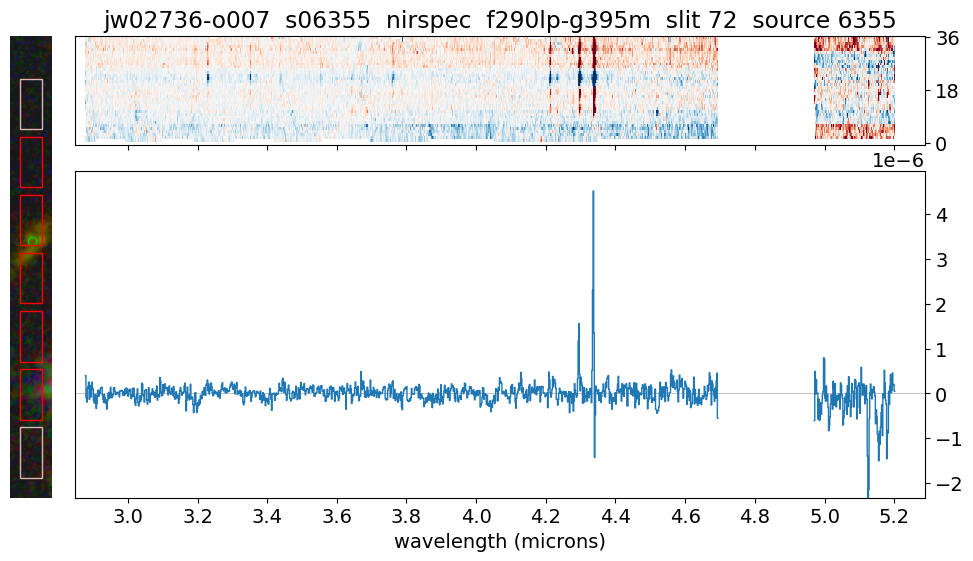

In [58]:
show_MOS_spectrum(s2d_model, x1d_model, source_id) #, save_plot=True)

### Load and display a different source

In [59]:
def load_and_show_MOS_spectrum(source_id):
    s2d_file = 'jw02736-o007_s%05d_nirspec_f290lp-g395m_s2d.fits' % source_id
    s2d_file = download_jwst_files([s2d_file], data_dir)[0]
    s2d_model = datamodels.open(s2d_file)
    
    x1d_file = s2d_file.replace('s2d', 'x1d')
    x1d_file = download_jwst_files([x1d_file], data_dir)[0]
    x1d_model = datamodels.open(x1d_file)
    
    show_MOS_spectrum(s2d_model, x1d_model, source_id) #, save_plot=True)

2024-06-17 16:02:02,787 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


Expanding wavelength gap 4.22 -- 4.48 microns


2024-06-17 16:02:02,796 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
2024-06-17 16:02:02,799 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


2D limits: -0.3719373047351837 0.3627185523509979
1D limits: -2.9628160789893633e-07 2.7151238309910966e-06


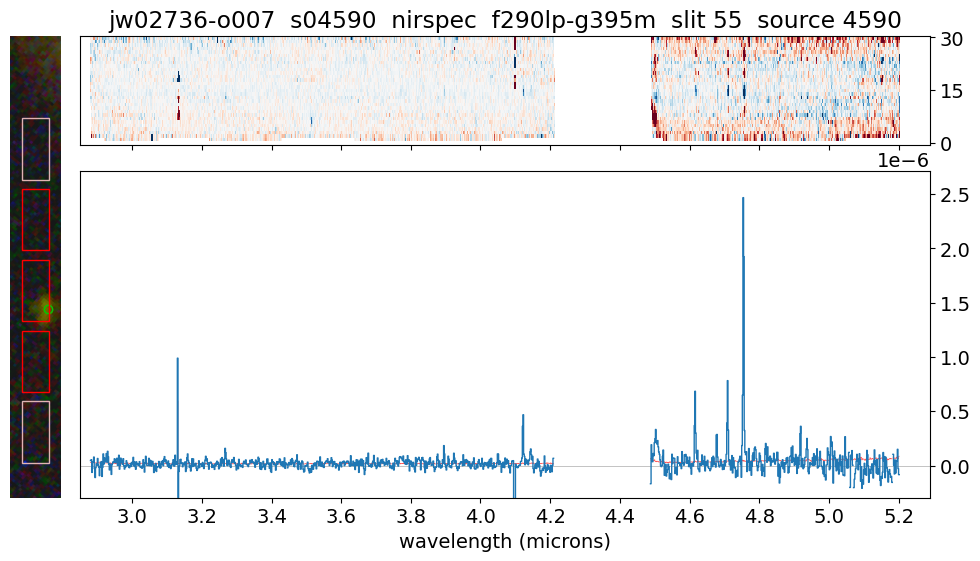

In [60]:
source_id = 4590  # z = 8.498
load_and_show_MOS_spectrum(source_id)

data/jw02736-o007_s10612_nirspec_f290lp-g395m_s2d.fits EXISTS


2024-06-17 16:02:03,497 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
2024-06-17 16:02:03,516 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
2024-06-17 16:02:03,519 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


data/jw02736-o007_s10612_nirspec_f290lp-g395m_x1d.fits EXISTS
Expanding wavelength gap 4.60 -- 4.86 microns
2D limits: -0.6698514819145203 0.6566171050071716
1D limits: -1.1534110773479e-06 1.116107541550138e-05


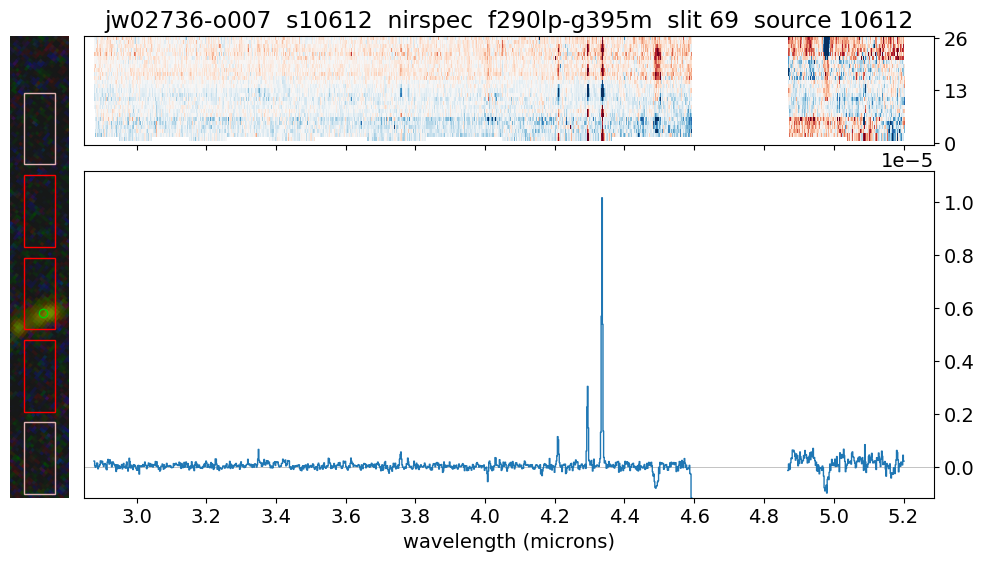

In [61]:
load_and_show_MOS_spectrum(10612)  # z = 7.663

Expanding wavelength gap 4.45 -- 4.72 microns


2024-06-17 16:02:04,569 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


2D limits: -0.44965997338294983 0.4088306427001953


2024-06-17 16:02:04,600 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
2024-06-17 16:02:04,605 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


1D limits: -4.6858389586844554e-07 1.388925501653221e-06


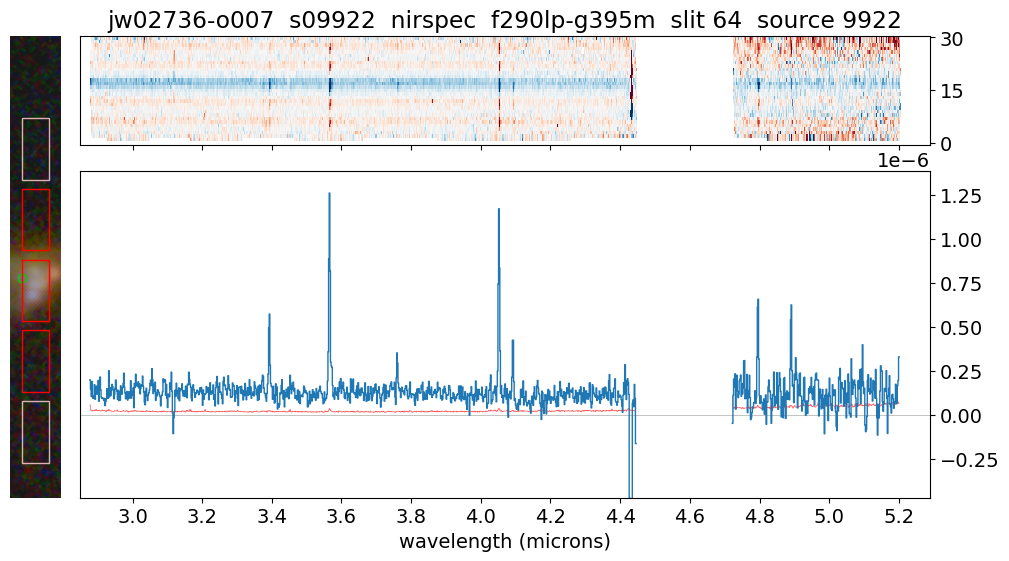

In [62]:
load_and_show_MOS_spectrum(9922)  # z = 2.743